# Import necessary libraries

In [1]:
import torch
import torchvision.transforms as transforms
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics.pairwise import paired_distances
import json
import pandas as pd
from sklearn.cluster import KMeans
from transformers import CLIPImageProcessor, CLIPModel
from collections import defaultdict

In [2]:
dir_path = 'Dataset'

In [9]:
class Dataset:
    def __init__(self, img_dir_path):
        self.img_dir_path = img_dir_path

    def img_files(self, n=False):
        files = []
        for path in os.listdir(self.img_dir_path):
            if os.path.isfile(os.path.join(self.img_dir_path, path)):
                files.append(path)
        if n:
            random_files = random.sample(files, n)
            return random_files
        else:
            return files
    
    def json_file_opening(self, json_file, attr_1, attr_2, dictionary=False, reshaping=False, tensor=False):
        with open(json_file, 'r') as file:
            img_features = [(json.loads(line)[attr_1],
                 json.loads(line)[attr_2])
                  for line in file]
        img_list = [feature[0] for feature in img_features]
        feature_list = [feature[1] for feature in img_features]
        if dictionary == False:
            return img_list, feature_list
        else:
            dict_list = {}
            assert len(img_list) == len(feature_list)
            for i in range(len(img_list)):
                if reshaping == True:
                    dict_list[img_list[i]] = np.array(feature_list[i]).reshape(1, -1)
                elif tensor == True:
                    dict_list[img_list[i]] = torch.FloatTensor(feature_list[i]).unsqueeze(dim=0)
                else:
                    dict_list[img_list[i]] = feature_list[i]
            return dict_list
    
    def dataset_target_dataframe(self, img_clip):
        with open('dataset.json', 'r') as dataset:
            dataset_list = [(
                json.loads(line)['file_img1'],
                json.loads(line)['file_img2'],
                json.loads(line)['target'])
                for line in dataset if
                img_clip.get(json.loads(line)['file_img1']) is not None and
                img_clip.get(json.loads(line)['file_img2']) is not None
                ]
        img_data = pd.DataFrame(dataset_list, columns=['img_clip_1', 'img_clip_2', 'target'])
        return img_data

# Represent Image Analytics class
In this class we implement function for finding nearest clusters for each image in our dataset

In [4]:
def to_1D(series):
    return [x for _list in series for x in _list]

In [5]:
class ImageAnalytics:
    def __init__(self, img_list):
        self.img_list = img_list
    
    def nearest_clusters(self, img_number, clusters_number, nearest, clusters, nearest_clusters_number):
        nearest_clusters_dict = {}
        with open('nearest_clusters_images.json', 'w') as near:
            pass
        images_vect = [0] * img_number
        for i in range(img_number):
            images_clust = [0] * clusters_number
            for j in range(clusters_number):
                vector = nearest[i][clusters[i]]
                images_clust[j] = abs(vector - nearest[i][j])
            images_vect[i] = images_clust
        images_sorted = [0] * img_number
        for i in range(img_number):
            images_sorted[i] = sorted(images_vect[i])[:nearest_clusters_number]
            nearest_clusters = [0] * img_number
        for i in range(img_number):
            clusters_per_img = [0] * nearest_clusters_number
            for j in range(nearest_clusters_number):
                clusters_per_img[j] = images_vect[i].index(images_sorted[i][j])
            nearest_clusters[i] = clusters_per_img
            with open('nearest_clusters_images.json', 'a') as near:
                nearest_clusters_json = {'img': self.img_list[i], 'clusters': nearest_clusters[i]}
                json.dump(nearest_clusters_json, near)
                near.write('\n')
            nearest_clusters_dict[self.img_list[i]] = nearest_clusters[i]
        return nearest_clusters_dict
    
    def nearest_clusters_images(self, nearest_cl_dict):
        nearest_clusters_images = {}
        zip_keys = [(value[0], key) for key, value in nearest_cl_dict.items()]
        clusters_images_2 = defaultdict(list)
        for key, value in zip_keys:
            clusters_images_2[key].append(value)
        for key, values in nearest_cl_dict.items():
            nearest_clusters_images[key] = list(set(to_1D([clusters_images_2.get(value) for value in values])))
        data = {'image': nearest_clusters_images.keys(), 'candidate': nearest_clusters_images.values()}
        nearest_clusters_df = pd.DataFrame(data)
        nearest_clusters_df = nearest_clusters_df.explode('candidate', ignore_index=True)
        #nearest_clusters_df['clip_image'] = nearest_clusters_df['image'].apply(lambda x: img_clip.get(x))
        #nearest_clusters_df['clip_candidate'] = nearest_clusters_df['candidate'].apply(lambda x: img_clip.get(x))
        nearest_clusters_df = nearest_clusters_df.drop(
            nearest_clusters_df.loc[nearest_clusters_df['image'] == nearest_clusters_df['candidate']].index)
        return nearest_clusters_df
    
    def metrics_count(self, dataframe, feature_clip_1, feature_clip_2):
        clip_1 = list(dataframe[feature_clip_1].values)
        clip_2 = list(dataframe[feature_clip_2].values)
        assert len(clip_1) == len(clip_2)
        n = len(clip_1)
        cos_sim = [0] * n
        l2 = [0] * n
        for i in range(n):
            cos_sim[i] = (torch.nn.functional.cosine_similarity(clip_1[i], clip_2[i])).item()
            l2[i] = paired_distances(clip_1[i], clip_2[i], metric='l2')[0]
        dataframe['cossim'] = cos_sim
        dataframe['l2'] = l2
        return dataframe
    
    def candidates(self, dataframe, metric, n):
        dataframe = dataframe.drop(dataframe.loc[dataframe['image'] == dataframe['candidate']].index)
        dataframe = dataframe.drop(dataframe.loc[dataframe['cossim'] == 1].index)
        nearest_df = dataframe.reset_index(drop=True)
        if metric == 'cossim':
            grouping = nearest_df.groupby(['image'])[metric].nlargest(n)
        elif metric == 'l2':
            grouping = nearest_df.groupby(['image'])[metric].nsmallest(n)
        grouping_dict = grouping.to_dict()
        paired_tuples = [(key[0], nearest_df.iloc[key[1]]['candidate']) for key in grouping_dict.keys()]
        candidates_dict = defaultdict(list)
        for img, cand in paired_tuples:
            candidates_dict[img].append(cand)
        with open(f'image_image_candidates_{n}_{metric}.json', 'w') as file:
            pass
        for key, value in candidates_dict.items():
            json_dict = {'img': key, 'candidates': value}
            with open(f'image_image_candidates_{n}_{metric}.json', 'a') as candidates:
                json.dump(json_dict, candidates)
                candidates.write('\n')
        return candidates_dict

# Image Representation class
In this class we implement fuction for single image representation and mapping list of images

In [67]:
class ImageRepresentation:
    def __init__(self):
        pass

    def dataset_image_open(self, image):
        image = Image.open(f'{dir_path}/{image}')
        return image
    
    def images_single(self, image_list):
        n = len(image_list)
        count = 1
        plt.figure(figsize=(15, 15))
        for i in range(n):
            image = Image.open(f'{dir_path}/{image_list[i]}')
            #image = image.resize((512, 256), Image.ANTIALIAS)
            plt.subplot((n // 2) + (n % 2), 2, count), plt.imshow(image)
            count +=1
        plt.show()

# CLIP class
We represent function, which get clip embeddings for each feature

In [18]:
model_ID = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_ID)
preprocess = CLIPImageProcessor.from_pretrained(model_ID)

In [19]:
class CLIP:
    def __init__(self, image_list):
        self.image_list = image_list
    
    def get_features(self):
        n = len(self.image_list)
        for i in range(n):
            try:
                image = Image.open(f'{dir_path}/{self.image_list[i]}')
                image = preprocess(image, return_tensors="pt")
                image = image["pixel_values"]
                with torch.no_grad():
                    embedding = model.get_image_features(image)
                    embedding = embedding.reshape(embedding.shape[1]).tolist()
            except:
                print(f'{i} is failed')
            else:
                img_clip = {'img': self.image_list[i], 'clip': embedding}
                with open('clip.json', 'a') as clip:
                    json.dump(img_clip, clip)
                    clip.write('\n')

# Image pipeline implementation

In [10]:
dataset = Dataset(dir_path)
img_list = dataset.img_files()

In [74]:
#clip = CLIP(img_list)
#features = clip.get_features()
clip_features = dataset.json_file_opening('clip.json', 'img', 'clip', dictionary=False, reshaping=False, tensor=False)[1]

In [85]:
clusters_number = 1000
nearest_clusters_number = 3
img_number = len(clip_features)

In [76]:
kmeans = KMeans(n_clusters=clusters_number)
clusters = kmeans.fit_predict(clip_features)
nearest = kmeans.fit_transform(clip_features)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Image metrics pipeline

In [11]:
analytics = ImageAnalytics(img_list)

In [77]:
img_clip = dataset.json_file_opening('clip.json', 'img', 'clip', dictionary=True, reshaping=False, tensor=True)
img_data = dataset.dataset_target_dataframe(img_clip)
#img_data = analytics.metrics_count(img_data, 'img_clip_1', 'img_clip_2')
img_data.to_csv('img_data.csv', index=False)

# Nearest clusters pipeline

In [86]:
#dataset = Dataset(dir_path)
#nearest_clusters = analytics.nearest_clusters(img_number, clusters_number, nearest, clusters, nearest_clusters_number)
nearest_clusters = dataset.json_file_opening('nearest_clusters.json', 'img', 'clusters', dictionary=True, reshaping=False, tensor=False)


In [94]:
nearest_clusters_df = analytics.nearest_clusters_images(nearest_clusters)
#nearest_clusters_df = analytics.metrics_count(nearest_clusters_df, 'clip_image', 'clip_candidate')

In [97]:
#nearest_clusters_df.to_csv('paired_images_clusters.csv', index=False)

# Image recommendation representation from image_pipeline

# We choose random image

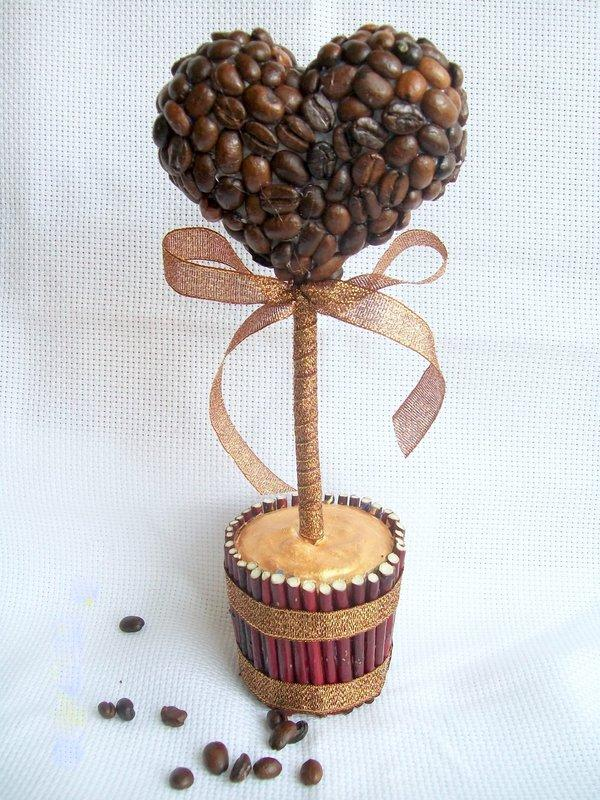

In [58]:
random_image = random.choice(list(candidates_dict_cossim.keys()))
represent = ImageRepresentation()
represent.dataset_image_open(random_image)

# We show candidates according cossim metrics

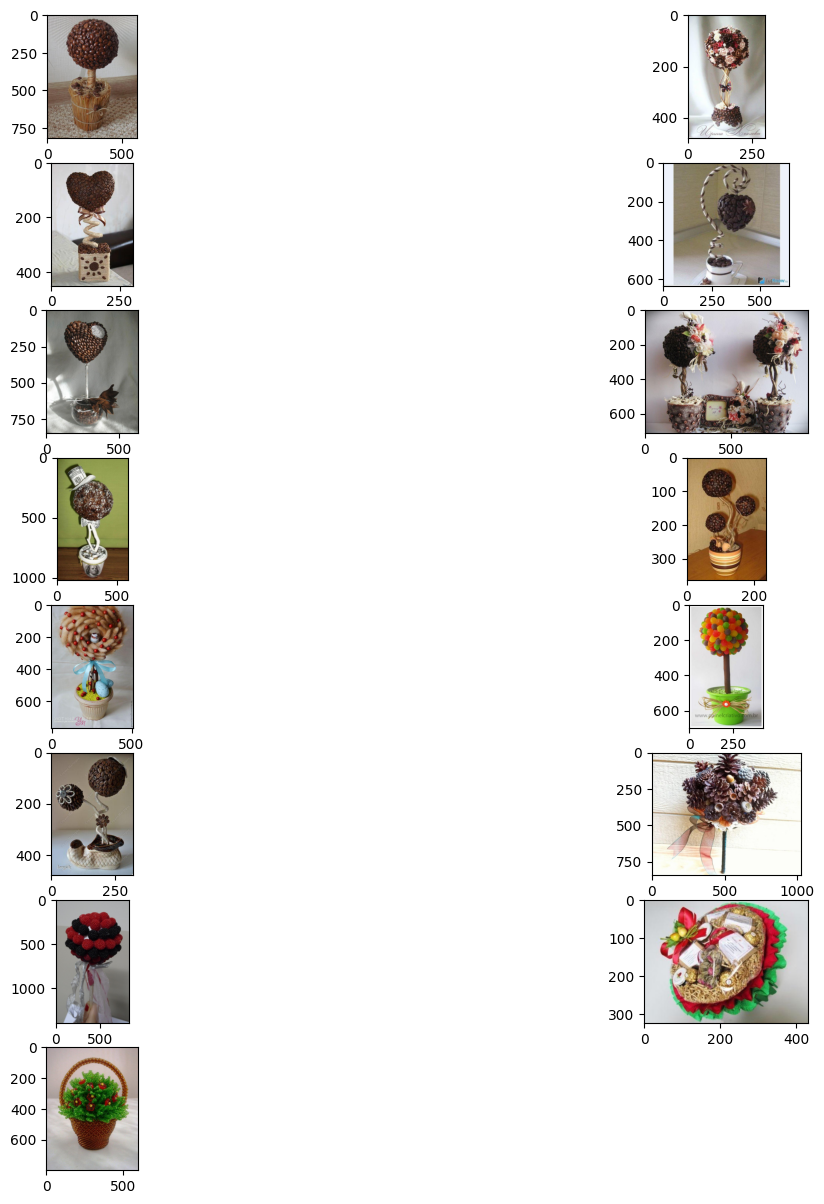

In [59]:
represent.images_single(candidates_dict_cossim.get(random_image))

# We show candidates according l2 metrics

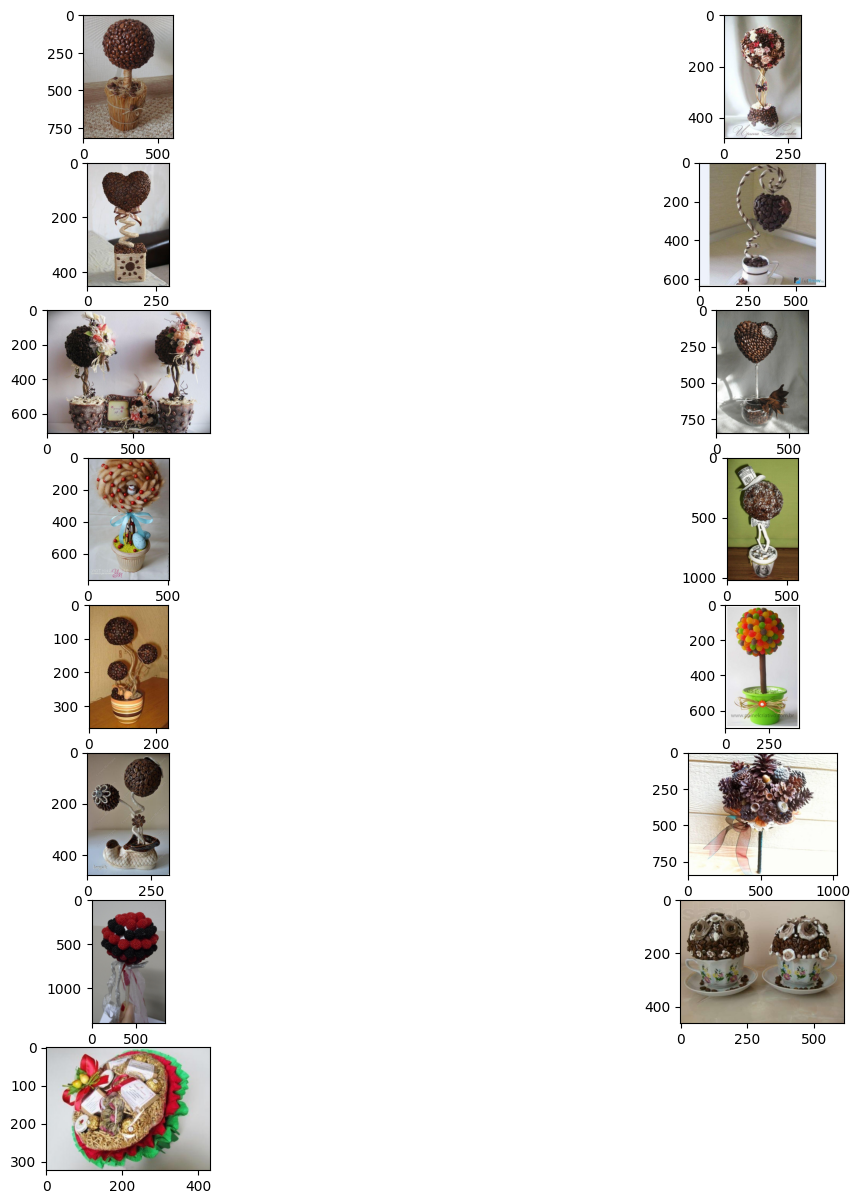

In [60]:
represent.images_single(candidates_dict_l2.get(random_image))